In [2]:
import os
import numpy as np
import nibabel as nib
import torch
import mridc
import h5py
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
def view_mri(data_dir, file_index=0, index=0, coil=0, figsize=(15, 4), show_real_imgag=False, save_location=None):
    file_names = os.listdir(data_dir)
    mri = h5py.File(os.path.join(data_dir, sorted(file_names)[file_index]), 'r')

    maps = []
    for key in mri.keys():
        field = mri[key]
        if len(field.shape)== 3:
            field = field[index, :, :]
        elif len(field.shape)== 4:
            field = field[index, coil, :, :]
            
        if np.iscomplex(field).any():
            map = np.abs(field)
            if key == "kspace":
                map = np.log(map + 1e-9)
            maps.append(map)
            if show_real_imgag:
                maps.append(np.real(field))
                maps.append(np.imag(field))
        else:
            maps.append(field)

    fig = plt.figure(figsize=figsize)
    for i, num in enumerate(maps):
        plt.subplot(1, len(maps), i + 1)
        ax = plt.imshow(num, cmap="gray")
        plt.colorbar(ax)
    plt.tight_layout()
    if save_location:
        plt.savefig(save_location, bbox_inches='tight', dpi=300, format='png')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/lgdejong/scratch/projects/mridc/mridc_experiments/example.png'

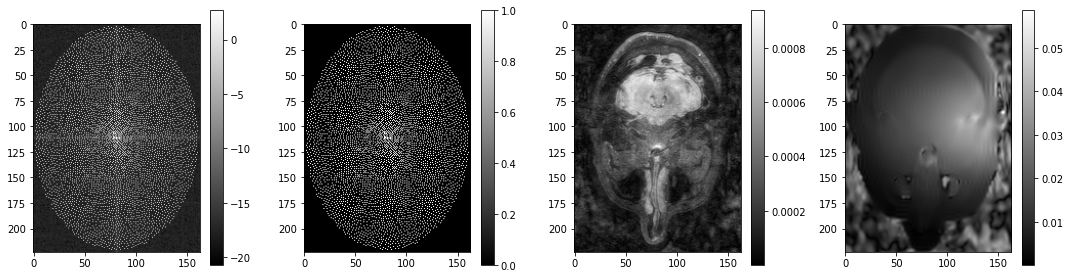

In [6]:
data_dir = "/data/projects/tecfidera/data/h5_new/nonorm/"

file_index = 0
index = 120
coil = 15

view_mri(data_dir, index=index, coil=coil, file_index=file_index, save_location="/home/lgdejong/scratch/projects/mridc/mridc_experiments/example.png")

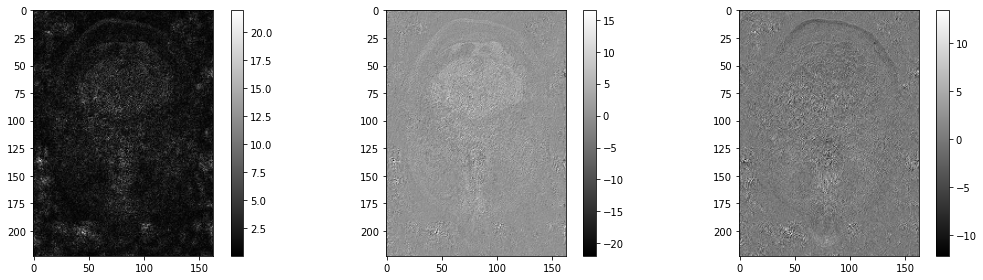

In [65]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_13-51-56/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

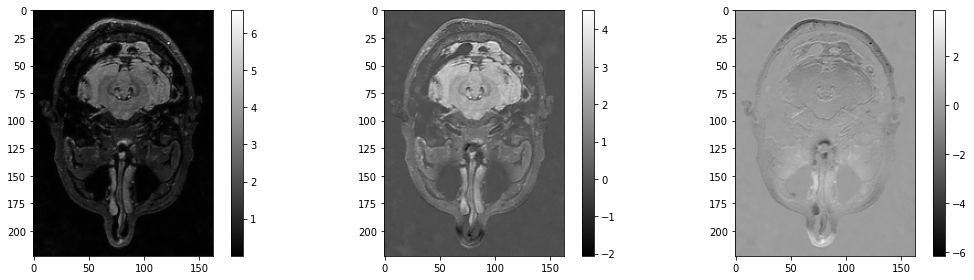

In [66]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_14-51-04/reconstructions/"


view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

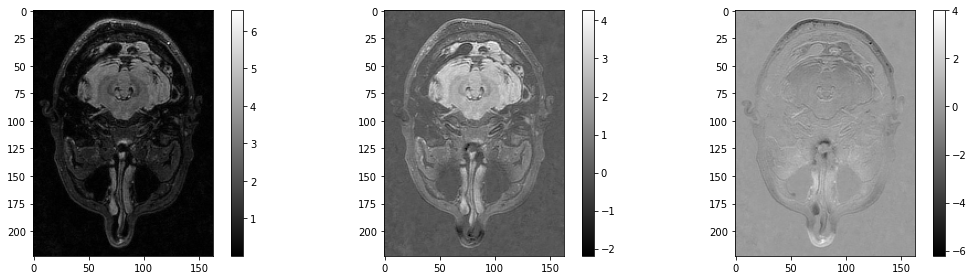

In [67]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_15-55-18/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

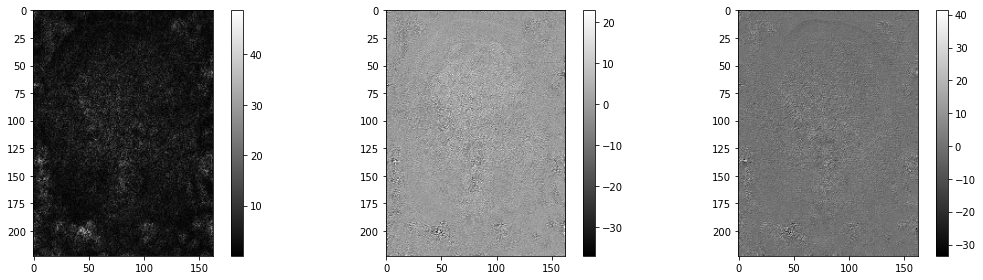

In [68]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_16-50-08/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

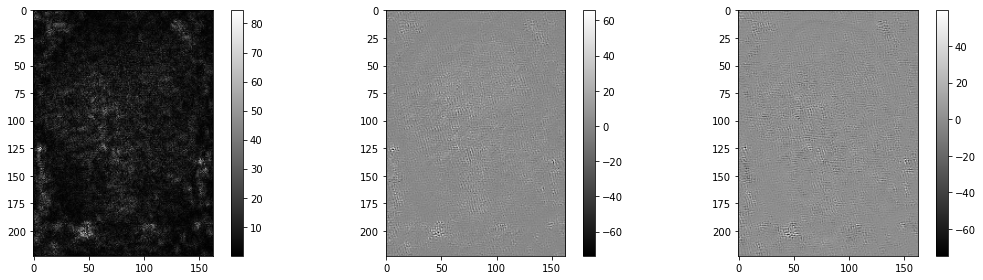

In [69]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_17-35-53/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

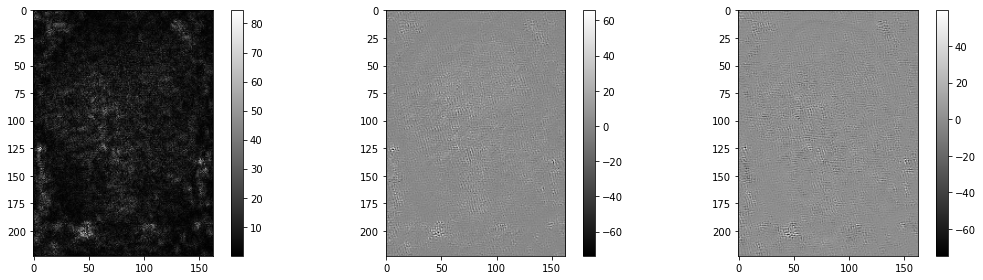

In [70]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_17-35-53/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

In [46]:
from mridc.collections.common.parts.utils import complex_mul, to_tensor, tensor_to_complex_np
from mridc.collections.common.parts.fft import fft2c, ifft2c

def load_seg(data_path):
    seg_test = np.array(nib.load(data_path).dataobj)
    seg_test = np.transpose(seg_test, (2, 1, 0))
    seg_test = np.flip(seg_test, (0))
    seg_test = np.flip(seg_test, (2))
    return seg_test

def voting_segmentation(segmentation_data_path="/data/projects/tecfidera/data/segmentations/NiftiSegmentations/", folder="lesions", file_name="lesion" ,extension=".nii.gz"):
    results = {}

    lesions_path = os.path.join(segmentation_data_path, folder)

    subjects_h5 = sorted(os.listdir("/data/projects/tecfidera/data/h5/"))
    subjects_id = [i[:6] for i in subjects_h5]

    loop_list = sorted(os.listdir(lesions_path))
    master_list = []
    for i in subjects_id:
        tmp_file_list = [j for j in loop_list if i in j]
        master_list.append(tmp_file_list)

    for i, name in zip(master_list, subjects_h5):
        results[name] = np.add.reduce([load_seg(os.path.join(lesions_path, j, f"FLAIR_{file_name}{extension}")) for j in i])
        results[name] = results[name]/len(i)
        results[name] = np.clip(results[name], 0.0, 1.0)
    return results

def combine_segmentations():
    results = {}
    lesions = voting_segmentation(folder="lesions", file_name="lesion")
    whitematter = voting_segmentation(folder="whitematter", file_name="whitematter", extension=".nii")
    graymatter = voting_segmentation(folder="graymatter", file_name="graymatter", extension=".nii")

    for i in lesions.keys():
        results[i] = np.zeros((*lesions[i].shape, 4))
        
        tmp = np.add.reduce([graymatter[i], whitematter[i]])
        with np.errstate(divide='ignore', invalid='ignore'):
            graymatter[i] = np.true_divide(graymatter[i],tmp)
            graymatter[i] = np.nan_to_num(graymatter[i], copy=False, nan=0.0, posinf=0.0, neginf=0.0)

            whitematter[i] = np.true_divide(whitematter[i],tmp)
            whitematter[i] = np.nan_to_num(whitematter[i], copy=False, nan=0.0, posinf=0.0, neginf=0.0)

        inv_lesions = 1 - lesions[i]
        graymatter[i] = graymatter[i] * inv_lesions
        whitematter[i] = whitematter[i] * inv_lesions

        results[i][..., 1] = graymatter[i] # graymatter
        results[i][..., 2] = whitematter[i] # whitematter
        results[i][..., 3] = lesions[i] # lesions
        results[i][..., 0] = 1 - np.add.reduce([graymatter[i], whitematter[i], lesions[i]]) #background
    return results

from mridc.collections.common.parts.fft import ifftshift, fftshift

def sense_expand(x, sense_maps):
        x = to_tensor(x)
        sense_maps = to_tensor(sense_maps)
        coils = complex_mul(x, sense_maps)
        if coils.shape[-1] == 2:
            coils = torch.view_as_complex(coils)
        kspace = torch.fft.fft2(coils, dim=[-2, -1], norm="ortho")
        return kspace.numpy().astype(np.complex64)

def reconstruct_kspace(dataset_path, recon_data_path, output_path, recon_model=None):
        dataset_files = sorted(os.listdir(dataset_path))
        recon_files = sorted(os.listdir(recon_data_path))
        segmentations_files = combine_segmentations()

        offset = [11, 5, 22, 14, 24, 8, 10, 11, 19, 11, 17, 14, 4, 8, 19, 20, 21, 10]

        transverse_dict = {}
        coronal_dict = {}
        sagittal_dict = {}
        for i, (dataset_file, recon_file, seg_file) in enumerate(zip(dataset_files, recon_files, segmentations_files)):
                data_path = os.path.join(dataset_path, dataset_file)
                recon_path = os.path.join(recon_data_path, recon_file)
                output = os.path.join(output_path, dataset_file[:-3])

                sense_maps = h5py.File(data_path, 'r')["sensitivity_map"]
                reconstrution = h5py.File(recon_path, 'r')["reconstruction"]
                seg_test = segmentations_files[dataset_file]

                sense_maps = np.fft.fftn(sense_maps, axes=(-2, -1))
                sense_maps = np.fft.fftshift(sense_maps, axes=(-2, -1))
                sense_maps = np.fft.ifftn(sense_maps, axes=(-2, -1))
                full_k_space = sense_expand(np.array(reconstrution), np.array(sense_maps)[offset[i]:offset[i]+200, ...])

                transverse_dict["kspace"] = full_k_space.astype(np.complex64)
                transverse_dict["sensitivity_map"] = np.array(sense_maps).astype(np.complex64)[offset[i]:offset[i]+200, ...]
                transverse_dict["reconstruction_sense"] = np.array(reconstrution).astype(np.complex64)
                transverse_dict["segmentation"] = seg_test.astype(np.float32)[offset[i]:offset[i]+200, ...]

                coronal_dict["reconstruction_sense"] = np.transpose(transverse_dict["reconstruction_sense"], axes=(2, 1, 0, 3)).astype(np.complex64)
                sagittal_dict["reconstruction_sense"] = np.flip(np.transpose(transverse_dict["reconstruction_sense"], axes=(3, 1, 0, 2)), axis=(-1)).astype(np.complex64)

                coronal_dict["sensitivity_map"] = np.transpose(transverse_dict["sensitivity_map"], axes=(2, 1, 0, 3)).astype(np.complex64)
                sagittal_dict["sensitivity_map"] = np.flip(np.transpose(transverse_dict["sensitivity_map"], axes=(3, 1, 0, 2)), axis=(-1)).astype(np.complex64)

                coronal_dict["segmentation"] = np.transpose(transverse_dict["segmentation"], axes=(1, 0, 2, 3)).astype(np.float32)
                sagittal_dict["segmentation"] = np.flip(np.transpose(transverse_dict["segmentation"], axes=(2, 0, 1, 3)), axis=(-2)).astype(np.float32)

                coronal_kspace = sense_expand(coronal_dict["reconstruction_sense"],  coronal_dict["sensitivity_map"])
                segittal_kspace = sense_expand(sagittal_dict["reconstruction_sense"],  sagittal_dict["sensitivity_map"])

                coronal_dict["kspace"] = coronal_kspace.astype(np.complex64)
                sagittal_dict["kspace"] = segittal_kspace.astype(np.complex64)

                with h5py.File(output + "_transverse.h5", "w") as hf:
                    for key, data in transverse_dict.items():
                        hf.create_dataset(key, data=data, compression=None)
                    if recon_model is not None:
                        hf.attrs['reconstruction_model'] = recon_model

                with h5py.File(output + "_coronal.h5", "w") as bf:
                    for key, data in coronal_dict.items():
                        bf.create_dataset(key, data=data, compression=None)
                    if recon_model is not None:
                        bf.attrs['reconstruction_model'] = recon_model

                with h5py.File(output + "_sagittal.h5", "w") as ff:
                    for key, data in sagittal_dict.items():
                        ff.create_dataset(key, data=data, compression=None)
                    if recon_model is not None:
                        ff.attrs['reconstruction_model'] = recon_model

In [47]:
ticfedera_data = "/data/projects/tecfidera/data/h5/"
recon_path = "/data/projects/tecfidera/data/h5_reconstructions/"
output = "/data/projects/tecfidera/data/h5_recon_dataset_new_test/"
reconstruct_kspace(ticfedera_data, recon_path, output, recon_model="fastmri_flair_320x320_CIRIM_8C_64F_l1_NODC")

(224, 32, 223, 163)


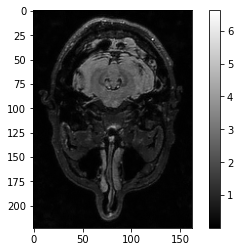

(224, 1, 223, 163)


In [72]:
partial_k_space = h5py.File("/data/projects/tecfidera/data/h5_new/nonorm/DMF007_T2_AXFLAIR.h5")
reconstrution = h5py.File("/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_14-51-04/reconstructions/DMF007_T2_AXFLAIR.h5")

sens_maps = partial_k_space["sensitivity_map"]
print(sens_maps.shape)
reconstrution = reconstrution["reconstruction"]
ax = plt.imshow((np.abs(reconstrution[index, 0, :, :])), cmap="gray")
plt.colorbar(ax)
plt.show()
print(reconstrution.shape)

In [73]:
full_k_sapce = sens_expand(np.array(reconstrution), np.array(sens_maps))

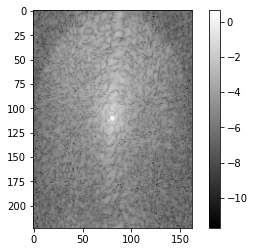

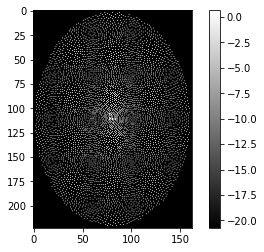

In [75]:
ax = plt.imshow(np.log(np.abs(full_k_sapce[index, 30, :, :])), cmap="gray")
plt.colorbar(ax)
plt.show()

ax = plt.imshow(np.log(np.abs(full_k_sapce[index, 30, :, :] * np.array(partial_k_space["mask"])) + 1e-9), cmap="gray")
plt.colorbar(ax)
plt.show()

In [33]:
segmentation_data_path = "/data/projects/tecfidera/data/segmentations/NiftiSegmentations/"
graymatter = os.path.join(segmentation_data_path, "graymatter")
lesions = os.path.join(segmentation_data_path, "lesions")
whitematter = os.path.join(segmentation_data_path, "whitematter")

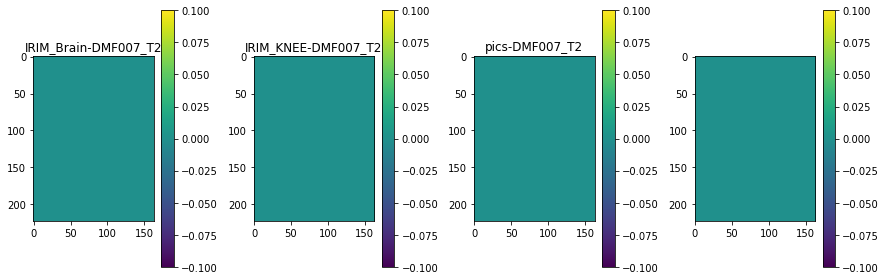

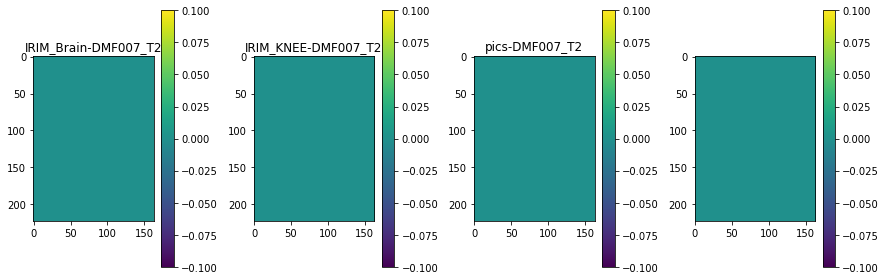

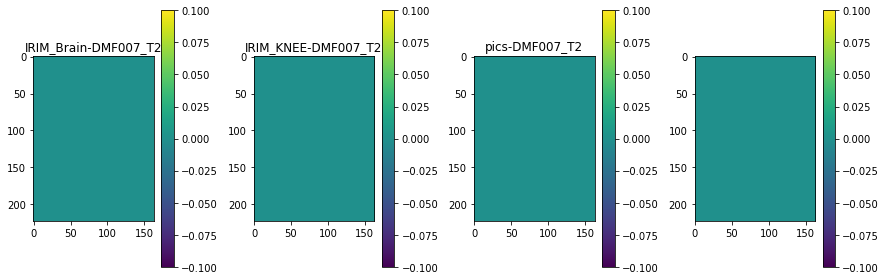

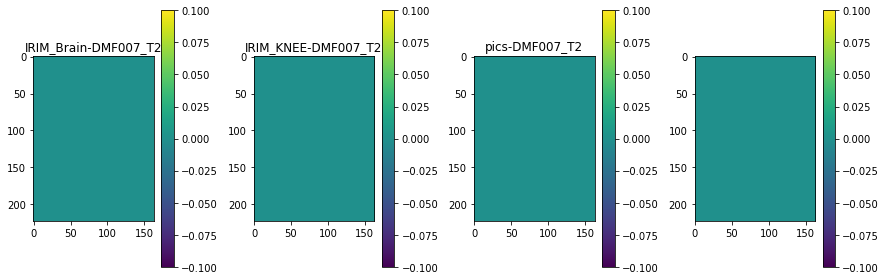

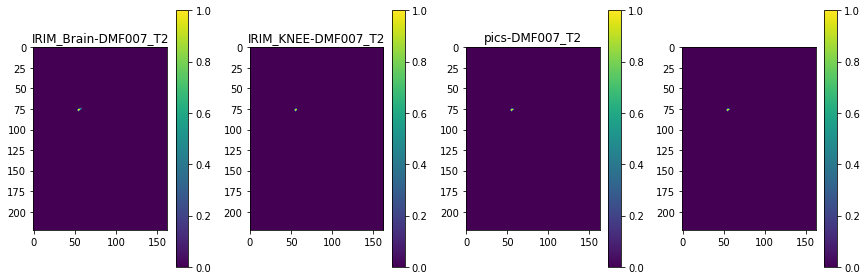

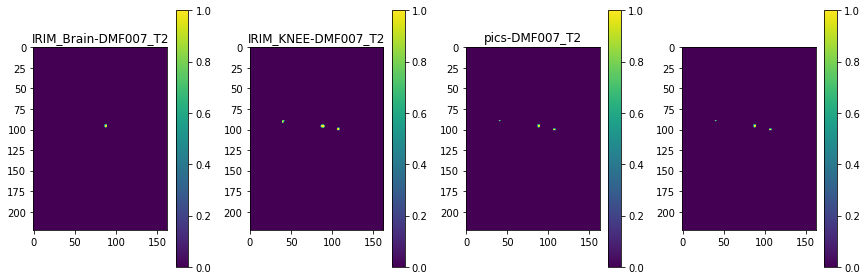

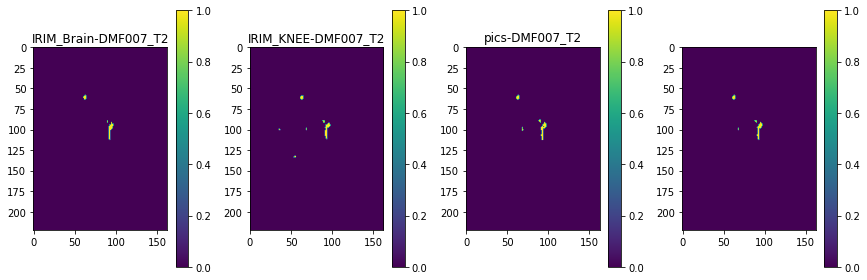

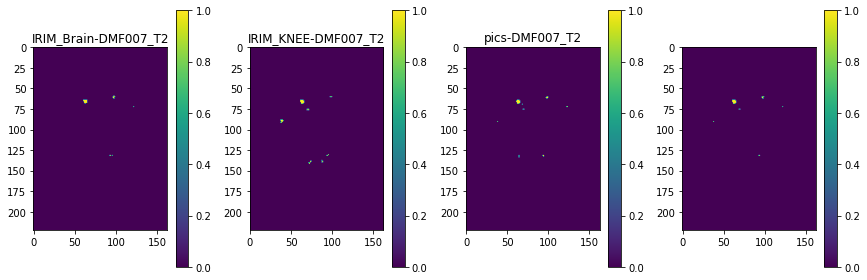

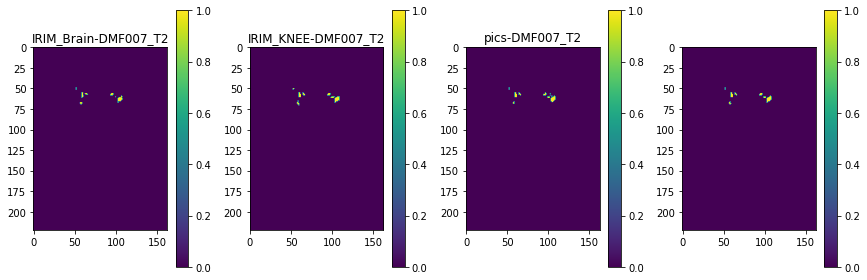

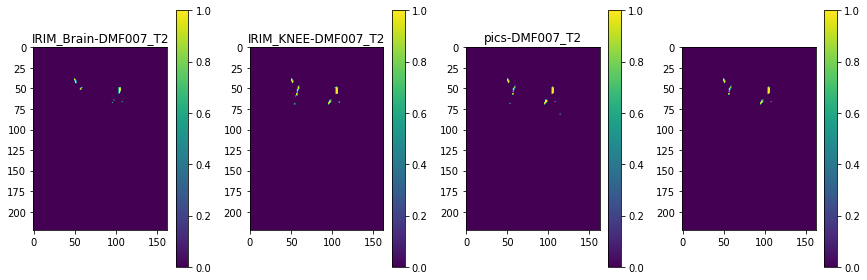

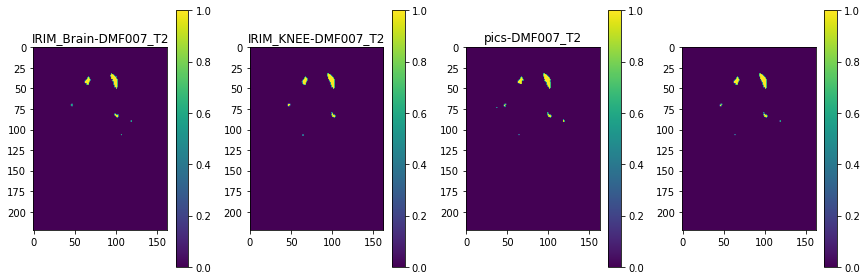

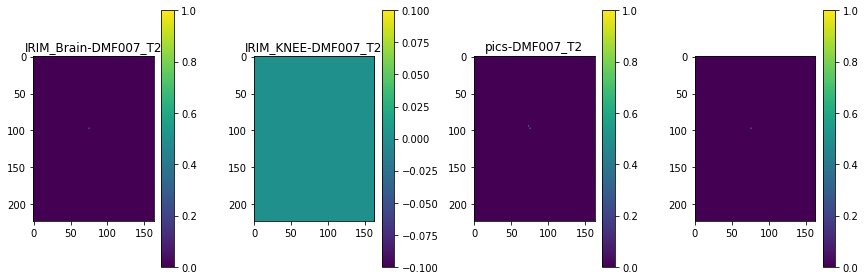

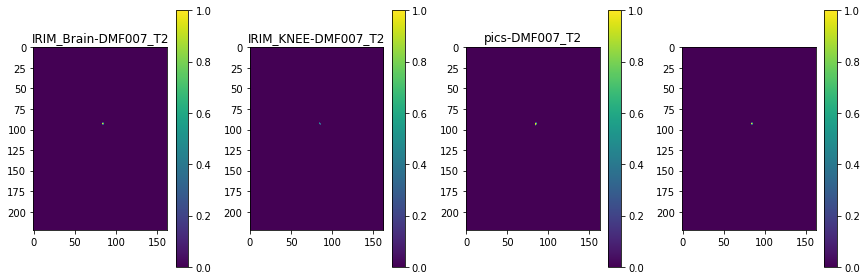

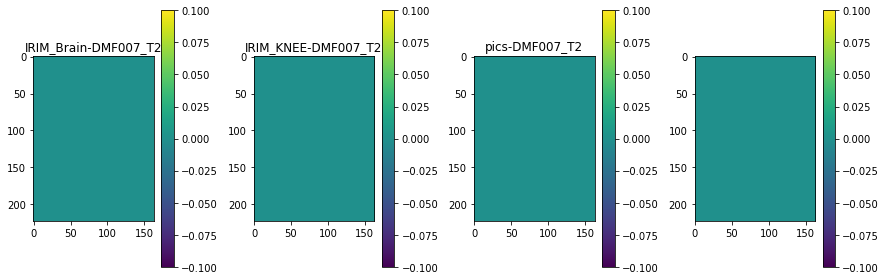

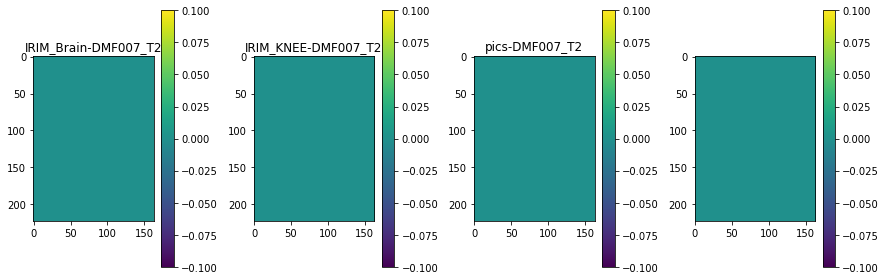

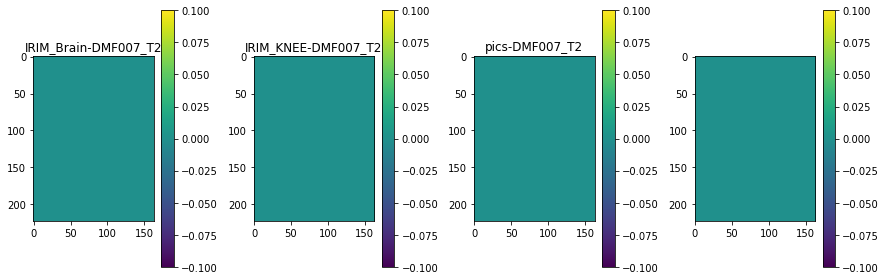

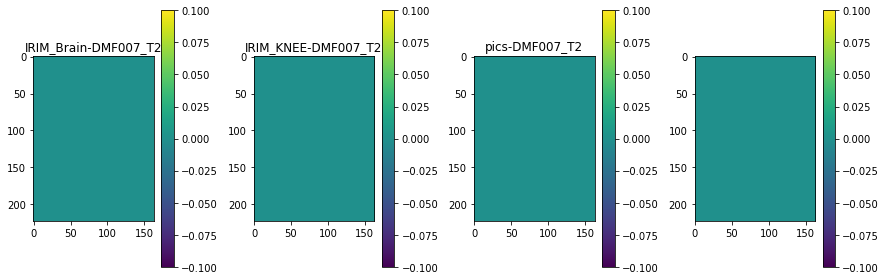

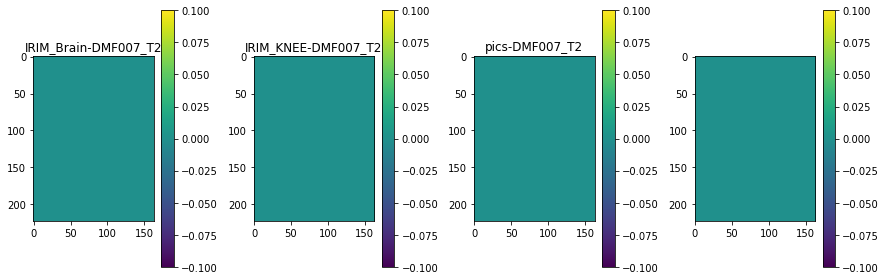

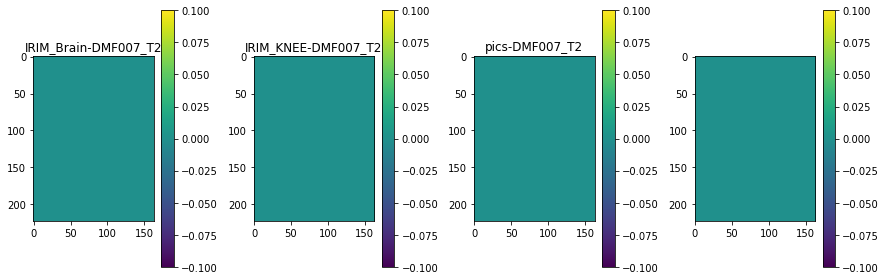

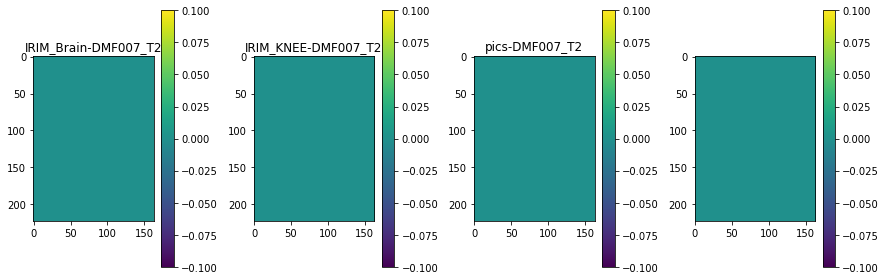

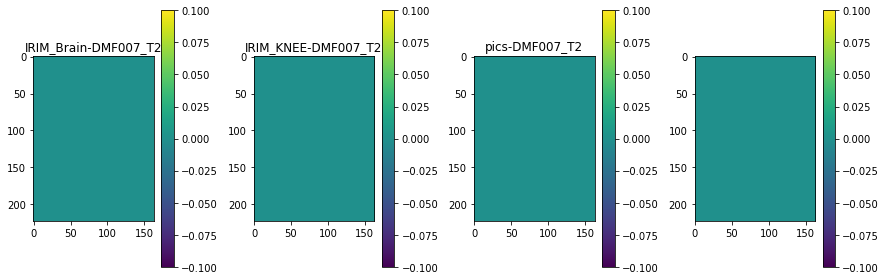

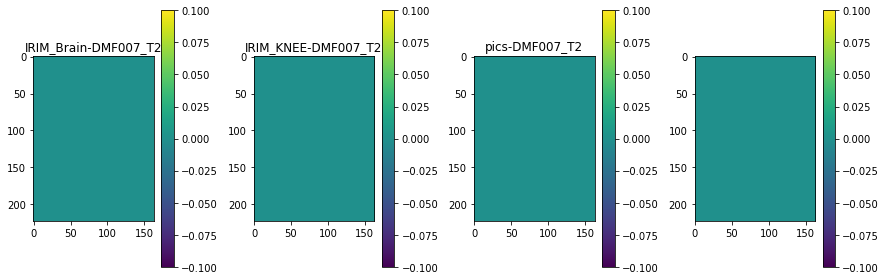

In [34]:
segmentation_dict = voting_segmentation()

subjects_id = os.listdir("/data/projects/tecfidera/data/h5_new/nonorm/")
subjects_id = [i[:6] for i in subjects_id]

loop_list = sorted(os.listdir(lesions))
master_list = []
for i in subjects_id:
    tmp_file_list = []
    for j in loop_list:
        if i in j:
            tmp_file_list.append(j)
    master_list.append(tmp_file_list)
# print(master_list)

for file_list in master_list:
    for j in range(0, 220, 10):
        fig = plt.figure(figsize=(15, 4))
        for cntr, i in enumerate(file_list):
            path = os.path.join(lesions, i, "FLAIR_lesion.nii.gz")
            segmentation = load_seg(path)

            plt.subplot(1, 5, cntr+1)
            ax = plt.imshow(segmentation[j, :, :])
            plt.colorbar(ax)
            plt.title(i)

        plt.subplot(1, 5, 4)
        ax = plt.imshow(segmentation_dict["DMF007_T2_AXFLAIR.h5"][j, : :])
        plt.colorbar(ax)

        # plt.subplot(1, 5, 5)
        # ax = plt.imshow(np.abs(reconstrution[j, 0, : :]), cmap="gray")
        # plt.colorbar(ax)

        plt.tight_layout()
        plt.show()
    break

In [27]:
recon_dataset_path = "/data/projects/tecfidera/data/h5_recon_dataset_new_test/"
recon_dataset_files = os.listdir(recon_dataset_path)

In [30]:
for i in recon_dataset_files:
    coronal_dict = {}
    sagittal_dict = {}
    hf = h5py.File(os.path.join(recon_dataset_path, i), 'r')

    output_coronal = os.path.join(recon_dataset_path, f"{i[:-14]}_coronal.h5")
    output_sagittal = os.path.join(recon_dataset_path, f"{i[:-14]}_sagittal.h5")

    


In [46]:
data_path = "/data/projects/tecfidera/data/h5_recon_dataset/"
tecfider_files = os.listdir(data_path)

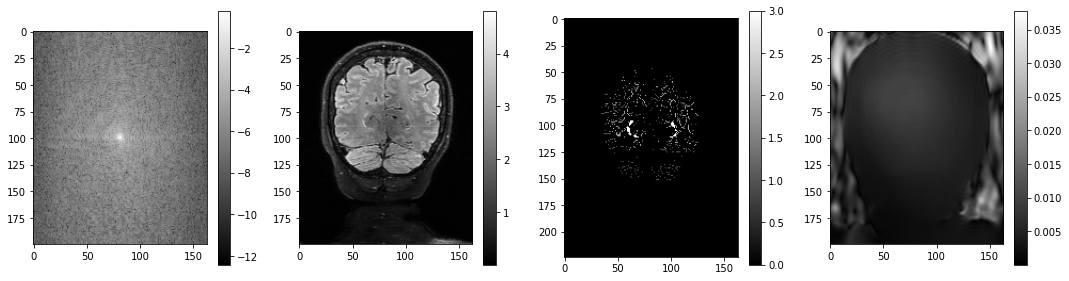

In [48]:
view_mri(data_path, index=40, coil=0, file_index=24)

In [17]:
input_path = "/data/projects/tecfidera/data/h5_recon_dataset_new/"
input_files = os.listdir(input_path)
input_files = [i for i in input_files if "transverse" in i]
input_files = sorted(input_files)

output_path = "/data/projects/tecfidera/data/h5_recon_new_2/"
for i in input_files:
    hf = h5py.File(os.path.join(input_path, i), 'r')
    output = os.path.join(output_path, f'{i[:17]}.h5')

    res = {"reconstruction": hf["reconstruction_sense"]}
    with h5py.File(output, "w") as ff:
        for key, data in res.items():
            ff.create_dataset(key, data=data, compression=None)

In [26]:
def binerize_segmentation(array):
    # print(array.shape)
    array_label =np.argmax(array
    , axis=-1)
    binairy_array = np.zeros_like(array)
    for i in range(array.shape[-1]):
        binairy_array[..., i] = array_label == i
    return binairy_array.astype(np.uint64)

In [11]:
mask_dict = combine_segmentations()

In [34]:
big_mask = np.add.reduce([binerize_segmentation(mask_dict[i]) for i in mask_dict.keys()])
weight = np.sum(big_mask, axis=(0, 1, 2)).astype(np.float32)[1:-1]
print(big_mask.shape, weight.shape)
print(weight)
# weight = 1/weight
weight = weight/np.sum(weight)
weight = 1 - weight
print(weight/np.sum(weight), np.sum(weight))
print(np.exp(weight - np.max(weight))/np.sum(np.exp(weight - np.max(weight))))
print(torch.softmax(torch.from_numpy(weight).float(), dim=0))

(224, 223, 163, 4) (2,)
[15326789.  9014424.]
[0.37033585 0.6296642 ] 0.99999994
[0.4355288 0.5644711]
tensor([0.4355, 0.5645])


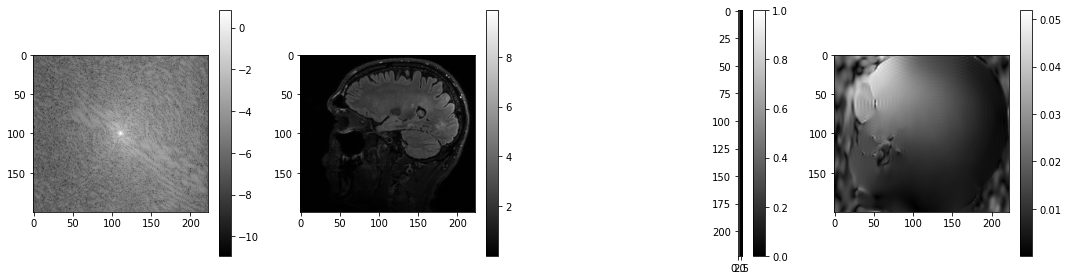

In [11]:
# view_mri("/scratch/lgdejong/results/reconstruction/cirim_1c_64f_poisson2d/", index=100, file_index=0)
view_mri("/data/projects/tecfidera/data/h5_recon_dataset_new/", index=100, file_index=1)